# Anomaly Field Imprtance BigML

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
print("Pandas Version: "+pd.__version__)
print("NumPy Version: "+np.__version__)
print("SeaBorn Version: "+sns.__version__)

Pandas Version: 0.23.0
NumPy Version: 1.14.3
SeaBorn Version: 0.8.1


In [3]:
import os
os.environ['BIGML_USERNAME'] = "efetoros"
os.environ['BIGML_API_KEY'] = "7e5fc6a649fd0f8517fc8ecf2ebd30151c5d4fb4"

In [4]:
from bigml.api import BigML
api = BigML()

### This function outputs a pandas dataframe containing a score column for anomaly scores.


In [263]:
def anomoly_distribution(file_name):
    source = api.create_source(file_name)
    api.ok(source)
    dataset = api.create_dataset(source)
    api.ok(dataset)
    anomaly = api.create_anomaly(dataset)
    api.ok(anomaly)
    batch_anomaly_score = api.create_batch_anomaly_score(anomaly, dataset,
                                                    {"all_fields" : True,
                                                    "importance": True})
    api.ok(batch_anomaly_score)
    api.download_batch_anomaly_score(batch_anomaly_score,
                                 filename=file_name+"_"+'anomaly_scores.csv')
    scores = pd.read_csv(file_name+"_"+"anomaly_scores.csv")
    return scores

In [264]:
diabetes = anomoly_distribution("diabetes_copy.csv")
diabetes.head(2)

,pregnancies,plasma glucose,blood pressure,triceps skin thickness,insulin,bmi,diabetes pedigree,age,diabetes,score,pregnancies importance,plasma glucose importance,blood pressure importance,triceps skin thickness importance,insulin importance,bmi importance,diabetes pedigree importance,age importance,diabetes importance
0,6,148,72,35,0,33.6,0.627,50,True,0.39669,0.11591,0.10865,0.05101,0.12134,0.05585,0.04786,0.08202,0.11895,0.29841
1,1,85,66,29,0,26.6,0.351,31,False,0.33728,0.16053,0.12813,0.07044,0.13400,0.08046,0.07031,0.09296,0.10698,0.15620


Download more datasets with anomaly scores as dataframes.


In [266]:
bank_marketing = anomoly_distribution("bank-additional-full.csv")
credit = anomoly_distribution("credit_data/credit.csv")
kidney_disease = anomoly_distribution("kidney_disease copy.csv")

### This function is a helper function that illustrates most of the work in this notebook. The function will return a ordered list of field names based on field importance score.

Parameters:
<ul>
<li>df: The data frame where the function will be computing field importance for anomalies
	

<li> threshold: If the threshold is left blank, the default will be set by the extreme right limit of a box and whisker plot. Otherwise we have to set the threshold.
	
<li> balance: decides whether to balance fields when creating ensembles
<li> ensemble: if true, the function decides to use a method of creating a target column from anomaly scores, training an ensemble on the newly transformed table, and using the field importance of that ensemble, if false, the function decides to use a method that retrievs a subset of instances' field importance scores from an anomaly object, and eventually averages them for a final set of field importance. 
<li> graph_info: decides whether to present a graph of the distribution, a box and whisker plot, and additional info.
<ul>

### Originally, when I first was setting thresholds, I also included a low threshold. So when labeling anomaly scores I labeled low middle and high, however, I concluded that setting a low threshold mishandled the data. Since we are focusing on the distribution of anomaly scores, the distribution will usually be right skewed with more instances with lower anomaly scores. This is because there usually won’t be a higher concentration of instances with high anomaly scores, if this was the case that would mean that there would be more outliers than what is considered the regular data.  Therefore, I think it makes more sense to have one threshold that splits instances that have a high anomaly score or otherwise a normal score. 


In [267]:
def anomaly_field_importance(df, threshold=0, balance=False, ensemble=True ,graph_info=True):
    
    boxplot= plt.boxplot(df["score"])
    plt.close()
    
    # d_extremes = [item.get_ydata() for item in B['whiskers']]
    if (threshold == 0):
        d_extremes = [item.get_ydata() for item in boxplot['whiskers']]
        threshold = d_extremes[1][1]
    else:
        threshold = np.percentile(df["score"], threshold)
        
#     anomaly_labeled = df["score"].apply(lambda x : "High Anomaly" if x >= high_thresh else ("Low Anomaly" if x <= low_thresh else "Mid Anomaly"))
    anomaly_labeled = df["score"].apply(lambda x : "High Anomaly" if x >= threshold else "Normal Anomaly")
    
    if graph_info:    
        print("Corresponding scores from set thresholds:")
        print("Threshold Score: "+ str(threshold))
        
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
   
        # Add a graph in each part
        sns.boxplot(df["score"], ax=ax_box)
        sns.distplot(df["score"], ax=ax_hist)
 
        # Remove x axis name for the boxplot
        ax_box.set(xlabel='')

    
        plt.axvline(x=threshold)
        
        print()
        print("Anomaly Counts:")
        print(anomaly_labeled.value_counts())
        
    
    df["anomaly_labeled"] = anomaly_labeled
    

    plt.show()
    
    if (ensemble==True):
        df = df.drop(df.loc[:,"score" :].columns[:-1],axis=1)
        df.to_csv("temp.csv")
        
        source = api.create_source("temp.csv")
        api.ok(source)

        dataset = api.create_dataset(source,{"excluded_fields":["field1"]})
        api.ok(dataset)

        Ensemble = api.create_ensemble(dataset, {"balance_objective" : balance})
        api.ok(Ensemble)
    
        field_importance = Ensemble["object"]["importance"]

        names_of_important_fields = {}
        for keys in field_importance.keys():
            names_of_important_fields[dataset['object']["fields"][keys]["name"]] = field_importance[keys]
        sorted_values = sorted(names_of_important_fields.items(), key=lambda kv: kv[1])
        return sorted_values
    else:
        df = df[df["anomaly_labeled"]=="High Anomaly"]
        df = df[df.loc[:,"score" :].drop(["score"],axis=1).columns[:-2]]
        holder= {}
        for column in df:
            holder[column] = np.mean(df[column])
        sorted_values = sorted(holder.items(), key=lambda kv: kv[1])
        return sorted_values

This method is for the creation of side by side barplots that compare outcomes of methods.

In [368]:
def side_by_side(e_method,a_method):
    df = pd.DataFrame(data={"fields":pd.Series([x[0] for x in e_method]), 
                           "field_importance" :pd.Series([x[1] for x in e_method]), 
                           "method": pd.Series(["Ensemble Method" for x in np.arange(len(e_method))])})
    df2 = pd.DataFrame(data={"fields":pd.Series([x[0][:-11] for x in a_method]), 
                            "field_importance" : pd.Series([x[1] for x in a_method]), 
                            "method": pd.Series(["Anomaly Method" for x in np.arange(len(a_method))])})
    df = df.append(df2)
    sns.set(style="whitegrid")

    g = sns.barplot(y="fields", x="field_importance", hue="method", data=df)

Corresponding scores from set thresholds:
Threshold Score: 0.56553

Anomaly Counts:
Normal Anomaly    762
High Anomaly        6
Name: score, dtype: int64


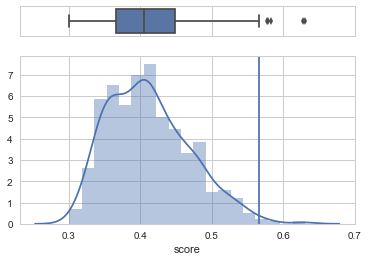

In [269]:
not_balanced_ensemble_diabetes = anomaly_field_importance(diabetes)
balanced_ensemble_diabetes = anomaly_field_importance(diabetes,balance=True,graph_info=False)
anomaly_mean_diabetes = anomaly_field_importance(diabetes,balance=True,ensemble=False,graph_info=False)

### After running the function, we can see that according to the box and whisker default threshold, we have 6 anomalies in our dataset. We ran the function three times, the first time we used the ensemble method and don't balance the two sides of the threshold, the second time we use the ensemble method and balance the fields so when the ensemble is created, it does not put too much emphasis on the many instances of normal anomalies in the target column, and the third time we ran it, we used the method of averaging the subest of anomalies field importance straight from our anomaly object.

In [270]:
not_balanced_ensemble_diabetes

[('blood pressure', 0.00763),
 ('diabetes', 0.01541),
 ('plasma glucose', 0.06595),
 ('pregnancies', 0.07961),
 ('diabetes pedigree', 0.10631),
 ('insulin', 0.11376),
 ('triceps skin thickness', 0.13825),
 ('bmi', 0.18511),
 ('age', 0.28797)]

In [271]:
balanced_ensemble_diabetes

[('diabetes pedigree', 0.03293),
 ('diabetes', 0.03397),
 ('pregnancies', 0.03717),
 ('age', 0.04699),
 ('blood pressure', 0.10028),
 ('insulin', 0.10044),
 ('bmi', 0.13018),
 ('triceps skin thickness', 0.152),
 ('plasma glucose', 0.36603)]

In [272]:
anomaly_mean_diabetes

[('bmi importance', 0.08196833333333334),
 ('blood pressure importance', 0.08289999999999999),
 ('pregnancies importance', 0.08891166666666667),
 ('insulin importance', 0.09865333333333333),
 ('age importance', 0.10598666666666666),
 ('diabetes pedigree importance', 0.10976000000000001),
 ('triceps skin thickness importance', 0.11687666666666667),
 ('plasma glucose importance', 0.12035333333333335)]

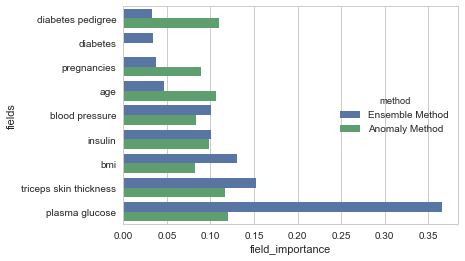

In [369]:
side_by_side(balanced_ensemble_diabetes,anomaly_mean_diabetes)

### An important note is that our two methods come out with much varying outcomes.

In [358]:
x = []
for i in np.arange(20):
    x.append(anomaly_field_importance(diabetes,balance=True,graph_info=False))

In [359]:
def comb(lst):
    if (len(lst) == 1):
        df1 = pd.DataFrame(data={"field_importance_scores":pd.Series([x[1] for x in lst[0]]), 
                           "fields" : pd.Series([x[0] for x in lst[0]])})
        return df1
    else: 
        df = comb([lst[0]]).append(comb(lst[1:]))
        return df

## The table below shows the std of field importance scores from running the ensemble balanced method 20 times. It is not a good sign that with every iteration, our field importance changes. 

In [360]:
comb(x).groupby("fields").std()

,field_importance_scores
fields,
age,0.074036
blood pressure,0.034508
bmi,0.061706
diabetes,0.027037
diabetes pedigree,0.049652
insulin,0.059755
plasma glucose,0.093919
pregnancies,0.011187
triceps skin thickness,0.049739


In [361]:
comb(x).groupby("fields").mean()

,field_importance_scores
fields,
age,0.181138
blood pressure,0.067673
bmi,0.156217
diabetes,0.019975
diabetes pedigree,0.101966
insulin,0.048588
plasma glucose,0.330201
pregnancies,0.038895
triceps skin thickness,0.062635


In [364]:
x = []
for i in np.arange(20):
    diabetes = anomoly_distribution("diabetes_copy.csv")
    x.append(anomaly_field_importance(diabetes,balance=True,ensemble=False,graph_info=False))

## Below we can see that the the method involving the direct retrieval of avg field importance from the anomaly object, does not vary during iterations

In [365]:
comb(x).groupby("fields").std()

,field_importance_scores
fields,
age importance,0.0
blood pressure importance,0.0
bmi importance,0.0
diabetes pedigree importance,0.0
insulin importance,0.0
plasma glucose importance,0.0
pregnancies importance,0.0
triceps skin thickness importance,0.0


Corresponding scores from set thresholds:
Threshold Score: 0.58204

Anomaly Counts:
Normal Anomaly    27154
High Anomaly       1273
Name: score, dtype: int64


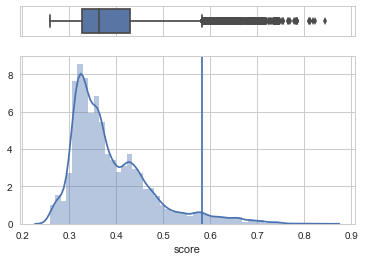

{'000001': 0.06491, '000002': 0.29688, '000003': 0.07449, '000004': 0.33264, '000005': 0.1028, '000006': 0.12829}
{'000001': 0.0479, '000002': 0.30423, '000003': 0.07274, '000004': 0.28327, '000005': 0.11166, '000006': 0.1802}


In [196]:
not_balanced_ensemble_credit = anomaly_field_importance(credit)
balanced_ensemble_credit = anomaly_field_importance(credit,balance=True,graph_info=False)
anomaly_mean_credit = anomaly_field_importance(credit,balance=True,ensemble=False,graph_info=False)

In [198]:
not_balanced_ensemble_credit

[('BUSAGE', 0.06491),
 ('MAXLINEUTIL', 0.07449),
 ('TOTACBAL', 0.1028),
 ('DEFAULT', 0.12829),
 ('BUSTYPE', 0.29688),
 ('DAYSDELQ', 0.33264)]

In [199]:
balanced_ensemble_credit

[('BUSAGE', 0.0479),
 ('MAXLINEUTIL', 0.07274),
 ('TOTACBAL', 0.11166),
 ('DEFAULT', 0.1802),
 ('DAYSDELQ', 0.28327),
 ('BUSTYPE', 0.30423)]

In [200]:
anomaly_mean_credit

[('BUSAGE importance', 0.10839912804399032),
 ('DAYSDELQ importance', 0.14904615868028306),
 ('BUSTYPE importance', 0.15458753338570327),
 ('TOTACBAL importance', 0.17142676355066766),
 ('MAXLINEUTIL importance', 0.21350673212882904)]

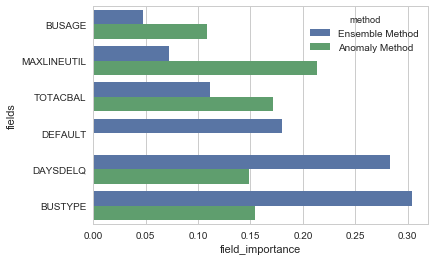

In [370]:
side_by_side(balanced_ensemble_credit,anomaly_mean_credit)

Corresponding scores from set thresholds:
Threshold Score: 0.59855

Anomaly Counts:
Normal Anomaly    399
High Anomaly        1
Name: score, dtype: int64


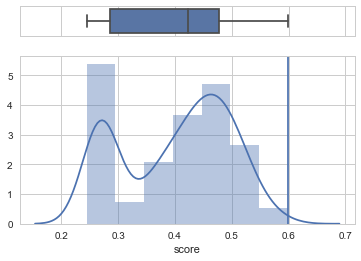

{'000005': 0.20783, '000007': 0.32287, '000010': 0.35638, '000012': 0.0226, '000013': 0.03572, '000014': 0.0546}
{'000005': 0.73519, '000010': 0.26236, '000014': 0.00246}


In [202]:
not_balanced_ensemble_kidney_disease = anomaly_field_importance(kidney_disease)
balanced_ensemble_kidney_disease = anomaly_field_importance(kidney_disease,balance=True,graph_info=False)
anomaly_mean_kidney_disease = anomaly_field_importance(kidney_disease,balance=True,ensemble=False,graph_info=False)

In [203]:
not_balanced_ensemble_kidney_disease

[('White Blood Cell Count', 0.0226),
 ('Red Blood Cell Count', 0.03572),
 ('Hypertension', 0.0546),
 ('Albumin', 0.20783),
 ('Red Blood Cells', 0.32287),
 ('Hemoglobin', 0.35638)]

In [204]:
balanced_ensemble_kidney_disease

[('Hypertension', 0.00246), ('Hemoglobin', 0.26236), ('Albumin', 0.73519)]

In [205]:
anomaly_mean_kidney_disease

[('id importance', 0.0),
 ('Age importance', 0.0037600000000000003),
 ('Bacteria importance', 0.0047),
 ('Coronary Artery Disease importance', 0.00703),
 ('Pus Cell Clumps importance', 0.00747),
 ('Anemia importance', 0.01285),
 ('Sugar importance', 0.01291),
 ('Pedal Edema importance', 0.013869999999999999),
 ('Specific Gravity importance', 0.015119999999999998),
 ('Appetite importance', 0.015519999999999999),
 ('Packed Cell Volume importance', 0.01706),
 ('Hemoglobin importance', 0.0224),
 ('White Blood Cell Count importance', 0.03532),
 ('Albumin importance', 0.041069999999999995),
 ('Red Blood Cell Count importance', 0.043289999999999995),
 ('Hypertension importance', 0.0454),
 ('Diabetes Mellitus importance', 0.04629),
 ('Red Blood Cells importance', 0.05719),
 ('Sodium importance', 0.06433),
 ('Pus Cell importance', 0.07707),
 ('Potassium importance', 0.07731),
 ('Blood Urea importance', 0.07885),
 ('Serum Creatinine importance', 0.07912000000000001),
 ('Blood Pressure importance

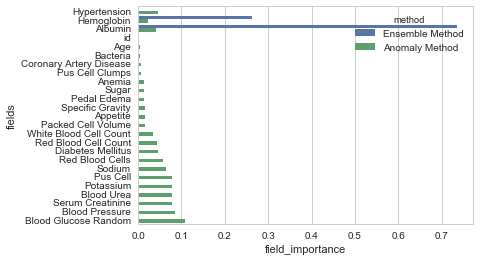

In [374]:
side_by_side(balanced_ensemble_kidney_disease,anomaly_mean_kidney_disease)

Corresponding scores from set thresholds:
Threshold Score: 0.6231399999999999

Anomaly Counts:
Normal Anomaly    40676
High Anomaly        512
Name: score, dtype: int64


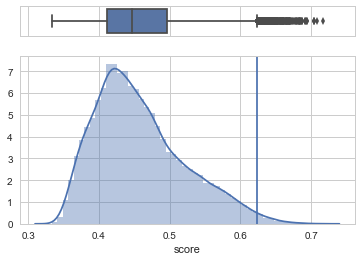

{'000001': 0.09945, '000002': 0.04607, '000003': 0.02097, '000004': 0.01521, '000005': 0.0428, '000006': 0.07481, '000007': 0.05717, '000008': 0.02697, '000009': 0.02275, '00000a': 0.00745, '00000b': 0.05421, '00000c': 0.0154, '00000d': 0.25716, '00000e': 0.05524, '00000f': 0.01508, '000010': 0.00984, '000011': 0.03344, '000012': 0.05714, '000013': 0.05422, '000014': 0.02396, '000015': 0.01064}
{'000001': 0.06057, '000002': 0.03988, '000003': 0.01067, '000004': 0.01355, '000005': 0.01586, '000006': 0.094, '000007': 0.0248, '000008': 0.01021, '000009': 0.0222, '00000a': 0.01015, '00000b': 0.02758, '00000c': 0.0091, '00000d': 0.25261, '00000e': 0.02108, '00000f': 0.17409, '000010': 0.00307, '000011': 0.0106, '000012': 0.01819, '000013': 0.13931, '000014': 0.01565, '000015': 0.02682}


In [207]:
not_balanced_ensemble_bank_marketing = anomaly_field_importance(bank_marketing)
balanced_ensemble_bank_marketing = anomaly_field_importance(bank_marketing,balance=True,graph_info=False)
anomaly_mean_bank_marketing = anomaly_field_importance(bank_marketing,balance=True,ensemble=False,graph_info=False)

In [208]:
not_balanced_ensemble_bank_marketing

[('day_of_week', 0.00745),
 ('emp.var.rate', 0.00984),
 ('y', 0.01064),
 ('poutcome', 0.01508),
 ('education', 0.01521),
 ('campaign', 0.0154),
 ('marital', 0.02097),
 ('month', 0.02275),
 ('nr.employed', 0.02396),
 ('contact', 0.02697),
 ('cons.price.idx', 0.03344),
 ('default', 0.0428),
 ('job', 0.04607),
 ('duration', 0.05421),
 ('euribor3m', 0.05422),
 ('previous', 0.05524),
 ('cons.conf.idx', 0.05714),
 ('loan', 0.05717),
 ('housing', 0.07481),
 ('age', 0.09945),
 ('pdays', 0.25716)]

In [209]:
balanced_ensemble_bank_marketing

[('emp.var.rate', 0.00307),
 ('campaign', 0.0091),
 ('day_of_week', 0.01015),
 ('contact', 0.01021),
 ('cons.price.idx', 0.0106),
 ('marital', 0.01067),
 ('education', 0.01355),
 ('nr.employed', 0.01565),
 ('default', 0.01586),
 ('cons.conf.idx', 0.01819),
 ('previous', 0.02108),
 ('month', 0.0222),
 ('loan', 0.0248),
 ('y', 0.02682),
 ('duration', 0.02758),
 ('job', 0.03988),
 ('age', 0.06057),
 ('housing', 0.094),
 ('euribor3m', 0.13931),
 ('poutcome', 0.17409),
 ('pdays', 0.25261)]

In [210]:
anomaly_mean_bank_marketing

[('duration importance', 0.017227324218749986),
 ('campaign importance', 0.017750449218749992),
 ('job importance', 0.02916121093749999),
 ('default importance', 0.029475742187499997),
 ('education importance', 0.03058771484375002),
 ('month importance', 0.03144109375),
 ('loan importance', 0.034900820312499976),
 ('previous importance', 0.038236132812499976),
 ('marital importance', 0.038873027343750005),
 ('contact importance', 0.03894796874999998),
 ('age importance', 0.039557246093749984),
 ('cons.price.idx importance', 0.042161601562499984),
 ('emp.var.rate importance', 0.04909757812500003),
 ('cons.conf.idx importance', 0.04973937499999997),
 ('housing importance', 0.05896863281249996),
 ('poutcome importance', 0.05931427734375001),
 ('day_of_week importance', 0.05966916015624999),
 ('euribor3m importance', 0.06862697265625),
 ('nr.employed importance', 0.07319691406250001),
 ('pdays importance', 0.11911224609374994)]

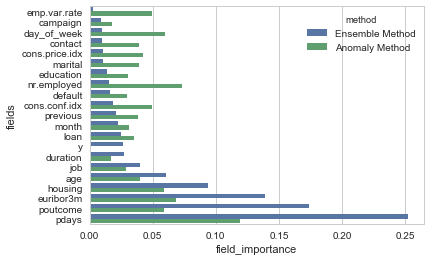

In [371]:
side_by_side(balanced_ensemble_bank_marketing,anomaly_mean_bank_marketing)

### From running the function and setting the thresholds based on box and whisker plots, we accurately identify anomalies, but this creates a problem since some datasets have almost no true anomalies, such as the chronic kidney disease dataset. Therefore, when labeling our low and high anomalies, our model has very little data to train on and might not accurately portray field importance. 


#### We will run the function for balanced and not balanced fields again for the diabetes dataset, except we will set the threshold to the 95th percentile instead of using a box and whisker plot.

Corresponding scores from set thresholds:
Threshold Score: 0.517817

Anomaly Counts:
Normal Anomaly    729
High Anomaly       39
Name: score, dtype: int64


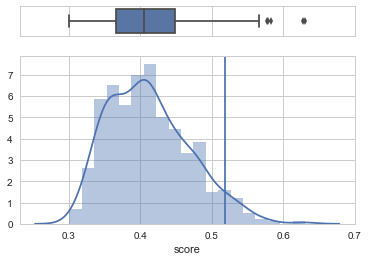

{'000001': 0.08214, '000002': 0.046, '000003': 0.0552, '000004': 0.04722, '000005': 0.08435, '000006': 0.36626, '000007': 0.1408, '000008': 0.17413, '000009': 0.0039}
{'000001': 0.0322, '000002': 0.05504, '000003': 0.06224, '000004': 0.04744, '000005': 0.08872, '000006': 0.37526, '000007': 0.14074, '000008': 0.19137, '000009': 0.007}


In [212]:
not_balanced_ensemble_diabetes_95 = anomaly_field_importance(diabetes,threshold=95)
balanced_ensemble_diabetes_95 = anomaly_field_importance(diabetes,threshold=95,balance=True,graph_info=False)
anomaly_mean_diabetes_95 = anomaly_field_importance(diabetes,threshold=95,balance=True,ensemble=False,graph_info=False)

In [213]:
not_balanced_ensemble_diabetes_95

[('diabetes', 0.0039),
 ('plasma glucose', 0.046),
 ('triceps skin thickness', 0.04722),
 ('blood pressure', 0.0552),
 ('pregnancies', 0.08214),
 ('insulin', 0.08435),
 ('diabetes pedigree', 0.1408),
 ('age', 0.17413),
 ('bmi', 0.36626)]

In [214]:
balanced_ensemble_diabetes_95

[('diabetes', 0.007),
 ('pregnancies', 0.0322),
 ('triceps skin thickness', 0.04744),
 ('plasma glucose', 0.05504),
 ('blood pressure', 0.06224),
 ('insulin', 0.08872),
 ('diabetes pedigree', 0.14074),
 ('age', 0.19137),
 ('bmi', 0.37526)]

In [215]:
balanced_ensemble_diabetes

[('insulin', 0.02124),
 ('pregnancies', 0.03463),
 ('diabetes pedigree', 0.03935),
 ('triceps skin thickness', 0.0641),
 ('blood pressure', 0.12959),
 ('bmi', 0.1537),
 ('plasma glucose', 0.26211),
 ('age', 0.29528)]

In [216]:
anomaly_mean_diabetes_95

[('insulin importance', 0.08188128205128205),
 ('blood pressure importance', 0.0913079487179487),
 ('diabetes pedigree importance', 0.09379282051282054),
 ('age importance', 0.09411051282051282),
 ('triceps skin thickness importance', 0.10198589743589745),
 ('plasma glucose importance', 0.10456333333333333),
 ('bmi importance', 0.10582179487179487),
 ('pregnancies importance', 0.1387933333333333)]

In [217]:
anomaly_mean_diabetes

[('bmi importance', 0.08196833333333334),
 ('blood pressure importance', 0.08289999999999999),
 ('pregnancies importance', 0.08891166666666667),
 ('insulin importance', 0.09865333333333333),
 ('age importance', 0.10598666666666666),
 ('diabetes pedigree importance', 0.10976000000000001),
 ('triceps skin thickness importance', 0.11687666666666667),
 ('plasma glucose importance', 0.12035333333333335)]

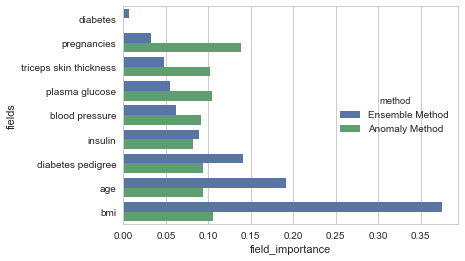

In [372]:
side_by_side(balanced_ensemble_diabetes_95,anomaly_mean_diabetes_95)

### We can see that since we added just a few new data points that wouldn't be considered an anomaly, our field importance started to resemble that of the unbalanced model.

### The reason it could still be useful for a user to put in a threshold is because datasets with a low number of instances might not have enough outliers or maybe outliers at all to search for field importance. For example, the dataset about chronic kidney disease only had one outlier and therefore the model had trouble training. 


#### Though maybe not the best solution, we can set the percentile for the chronic kidney disease dataset to 97 in order to derive better field importance. 

Corresponding scores from set thresholds:
Threshold Score: 0.5416617999999999

Anomaly Counts:
Normal Anomaly    388
High Anomaly       12
Name: score, dtype: int64


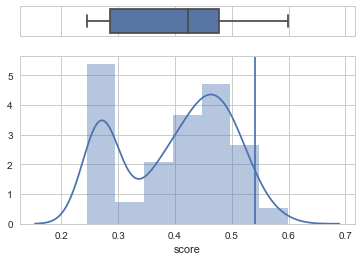

{'000002': 0.05135, '000003': 0.01689, '000005': 0.0209, '00000a': 0.00411, '00000b': 0.06576, '00000c': 0.32819, '00000d': 0.16897, '00000e': 0.13282, '00000f': 0.08153, '000010': 0.05627, '000012': 0.03457, '000014': 0.00114, '000015': 0.00239, '000016': 0.0351}
{'000002': 0.06126, '000003': 0.0857, '000005': 0.01028, '00000b': 0.0615, '00000c': 0.41542, '00000d': 0.00847, '00000e': 0.15849, '00000f': 0.14753, '000010': 0.03419, '000011': 0.0035, '000012': 0.00336, '000013': 0.00163, '000017': 0.00226, '000019': 0.00641}


In [219]:
not_balanced_ensemble_kidney_disease_97 = anomaly_field_importance(kidney_disease,threshold=97)
balanced_ensemble_kidney_disease_97 = anomaly_field_importance(kidney_disease,threshold=97,balance=True,graph_info=False)
anomaly_mean_kidney_disease_97 = anomaly_field_importance(kidney_disease,threshold=97,balance=True,ensemble=False,graph_info=False)

In [220]:
not_balanced_ensemble_kidney_disease_97

[('Hypertension', 0.00114),
 ('Diabetes Mellitus', 0.00239),
 ('Bacteria', 0.00411),
 ('Blood Pressure', 0.01689),
 ('Albumin', 0.0209),
 ('White Blood Cell Count', 0.03457),
 ('Coronary Artery Disease', 0.0351),
 ('Age', 0.05135),
 ('Hemoglobin', 0.05627),
 ('Blood Glucose Random', 0.06576),
 ('Potassium', 0.08153),
 ('Sodium', 0.13282),
 ('Serum Creatinine', 0.16897),
 ('Blood Urea', 0.32819)]

In [221]:
balanced_ensemble_kidney_disease_97

[('Red Blood Cell Count', 0.00163),
 ('Appetite', 0.00226),
 ('White Blood Cell Count', 0.00336),
 ('Packed Cell Volume', 0.0035),
 ('Anemia', 0.00641),
 ('Serum Creatinine', 0.00847),
 ('Albumin', 0.01028),
 ('Hemoglobin', 0.03419),
 ('Age', 0.06126),
 ('Blood Glucose Random', 0.0615),
 ('Blood Pressure', 0.0857),
 ('Potassium', 0.14753),
 ('Sodium', 0.15849),
 ('Blood Urea', 0.41542)]

In [222]:
balanced_ensemble_kidney_disease

[('Hypertension', 0.00246), ('Hemoglobin', 0.26236), ('Albumin', 0.73519)]

In [223]:
anomaly_mean_kidney_disease

[('id importance', 0.0),
 ('Age importance', 0.0037600000000000003),
 ('Bacteria importance', 0.0047),
 ('Coronary Artery Disease importance', 0.00703),
 ('Pus Cell Clumps importance', 0.00747),
 ('Anemia importance', 0.01285),
 ('Sugar importance', 0.01291),
 ('Pedal Edema importance', 0.013869999999999999),
 ('Specific Gravity importance', 0.015119999999999998),
 ('Appetite importance', 0.015519999999999999),
 ('Packed Cell Volume importance', 0.01706),
 ('Hemoglobin importance', 0.0224),
 ('White Blood Cell Count importance', 0.03532),
 ('Albumin importance', 0.041069999999999995),
 ('Red Blood Cell Count importance', 0.043289999999999995),
 ('Hypertension importance', 0.0454),
 ('Diabetes Mellitus importance', 0.04629),
 ('Red Blood Cells importance', 0.05719),
 ('Sodium importance', 0.06433),
 ('Pus Cell importance', 0.07707),
 ('Potassium importance', 0.07731),
 ('Blood Urea importance', 0.07885),
 ('Serum Creatinine importance', 0.07912000000000001),
 ('Blood Pressure importance

In [224]:
anomaly_mean_kidney_disease_97

[('id importance', 0.0),
 ('Age importance', 0.006908333333333335),
 ('Pus Cell Clumps importance', 0.008775),
 ('Bacteria importance', 0.01995),
 ('Blood Pressure importance', 0.024351666666666664),
 ('Sugar importance', 0.026225833333333334),
 ('Blood Urea importance', 0.03190333333333333),
 ('Red Blood Cells importance', 0.032116666666666675),
 ('Serum Creatinine importance', 0.03287833333333333),
 ('Specific Gravity importance', 0.03753583333333333),
 ('Pedal Edema importance', 0.03972083333333333),
 ('Packed Cell Volume importance', 0.04164166666666667),
 ('White Blood Cell Count importance', 0.04206916666666668),
 ('Albumin importance', 0.0421125),
 ('Anemia importance', 0.045708333333333344),
 ('Appetite importance', 0.046496666666666665),
 ('Sodium importance', 0.046669999999999996),
 ('Pus Cell importance', 0.046966666666666664),
 ('Coronary Artery Disease importance', 0.04820416666666666),
 ('Potassium importance', 0.048707499999999994),
 ('Red Blood Cell Count importance', 0

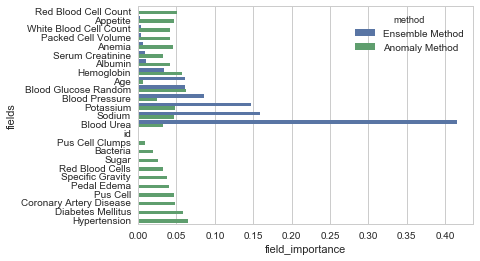

In [373]:
side_by_side(balanced_ensemble_kidney_disease_97,anomaly_mean_kidney_disease_97)